In [1]:
# Download dataset
#!kaggle datasets download -d emmarex/plantdisease

# Unzip the downloaded file
#!unzip plantdisease.zip

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from datetime import datetime
import os
from PIL import Image
import torchvision.transforms.functional as TF
from sklearn.model_selection import KFold

In [3]:
# Data transformations with data augmentation
# Perform feature engineering to improve model performance
transform = transforms.Compose([
    transforms.Resize(255),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(10),  # Randomly rotate the image by up to 10 degrees
    transforms.CenterCrop(224),
    transforms.ToTensor()
])


In [4]:
data_dir = 'PlantVillage'
dataset = datasets.ImageFolder(data_dir, transform=transform)

In [5]:
# Split dataset into training, validation, and test sets
indices = list(range(len(dataset)))
split = int(np.floor(0.85 * len(dataset)))
validation = int(np.floor(0.70 * split))

np.random.shuffle(indices)
train_indices, validation_indices, test_indices = (
    indices[:validation],
    indices[validation:split],
    indices[split:],
)

train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, sampler=train_sampler, batch_size=32)
validation_loader = torch.utils.data.DataLoader(dataset, sampler=validation_sampler, batch_size=32)
test_loader = torch.utils.data.DataLoader(dataset, sampler=test_sampler, batch_size=32)

In [6]:
# Number of classes in the dataset
targets_size = len(dataset.class_to_idx)


In [7]:
# Research and choose appropriate models
# Custom CNN model
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 28 * 28, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

custom_cnn = CustomCNN(targets_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
custom_cnn.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_custom_cnn = torch.optim.Adam(custom_cnn.parameters(), lr=0.001)


In [8]:
# Function to evaluate the model
def evaluate(model, dataloader, criterion):
    model.eval()
    loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, targets).item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    accuracy = 100. * correct / total
    return loss / len(dataloader), accuracy


In [9]:
# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.sampler)
        val_loss, val_accuracy = evaluate(model, val_loader, criterion)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')


In [10]:
# Implement a baseline model and evaluate it
# Train and evaluate the custom CNN model
train_model(custom_cnn, train_loader, validation_loader, criterion, optimizer_custom_cnn, num_epochs=10)
val_loss, val_accuracy = evaluate(custom_cnn, validation_loader, criterion)
print(f'Custom CNN - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')


Epoch 1/10, Train Loss: 1.4278, Validation Loss: 0.8417, Validation Accuracy: 73.00%
Epoch 2/10, Train Loss: 0.6830, Validation Loss: 0.4928, Validation Accuracy: 83.89%
Epoch 3/10, Train Loss: 0.5312, Validation Loss: 0.4276, Validation Accuracy: 85.48%
Epoch 4/10, Train Loss: 0.4306, Validation Loss: 0.3986, Validation Accuracy: 86.55%
Epoch 5/10, Train Loss: 0.3483, Validation Loss: 0.2671, Validation Accuracy: 91.09%
Epoch 6/10, Train Loss: 0.2993, Validation Loss: 0.3244, Validation Accuracy: 89.21%
Epoch 7/10, Train Loss: 0.2658, Validation Loss: 0.3818, Validation Accuracy: 86.95%
Epoch 8/10, Train Loss: 0.2377, Validation Loss: 0.2384, Validation Accuracy: 92.25%
Epoch 9/10, Train Loss: 0.2095, Validation Loss: 0.1973, Validation Accuracy: 93.35%
Epoch 10/10, Train Loss: 0.1565, Validation Loss: 0.1906, Validation Accuracy: 94.00%
Custom CNN - Validation Loss: 0.1840, Validation Accuracy: 94.26%


In [11]:
# Use cross-validation to check model reliability
from sklearn.model_selection import KFold

def cross_validate_model(model, dataset, criterion, k=3):
    kfold = KFold(n_splits=k, shuffle=True)
    results = []
    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)
        train_loader = torch.utils.data.DataLoader(dataset, sampler=train_sampler, batch_size=32)
        val_loader = torch.utils.data.DataLoader(dataset, sampler=val_sampler, batch_size=32)

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=3)

        val_loss, val_accuracy = evaluate(model, val_loader, criterion)
        results.append(val_accuracy)
        print(f'Fold {fold+1}, Validation Accuracy: {val_accuracy:.2f}%')

    print(f'Cross-Validation Results: {results}')
    print(f'Mean Accuracy: {np.mean(results):.2f}%, Std Dev: {np.std(results):.2f}%')


In [12]:
# Cross-validate the custom CNN model
cross_validate_model(custom_cnn, dataset, criterion, k=5)


Epoch 1/3, Train Loss: 0.2328, Validation Loss: 0.1694, Validation Accuracy: 94.36%
Epoch 2/3, Train Loss: 0.1940, Validation Loss: 0.1362, Validation Accuracy: 95.57%
Epoch 3/3, Train Loss: 0.1586, Validation Loss: 0.1370, Validation Accuracy: 95.64%
Fold 1, Validation Accuracy: 95.64%
Epoch 1/3, Train Loss: 0.1840, Validation Loss: 0.0715, Validation Accuracy: 98.13%
Epoch 2/3, Train Loss: 0.1387, Validation Loss: 0.1163, Validation Accuracy: 96.08%
Epoch 3/3, Train Loss: 0.1469, Validation Loss: 0.0825, Validation Accuracy: 97.36%
Fold 2, Validation Accuracy: 97.41%
Epoch 1/3, Train Loss: 0.1452, Validation Loss: 0.0562, Validation Accuracy: 98.09%
Epoch 2/3, Train Loss: 0.1222, Validation Loss: 0.0827, Validation Accuracy: 97.09%
Epoch 3/3, Train Loss: 0.1212, Validation Loss: 0.0702, Validation Accuracy: 97.67%
Fold 3, Validation Accuracy: 97.65%
Epoch 1/3, Train Loss: 0.1250, Validation Loss: 0.0451, Validation Accuracy: 98.67%
Epoch 2/3, Train Loss: 0.1082, Validation Loss: 0.06

In [13]:
# Batch gradient descent function
def batch_gd(model, criterion, optimizer, train_loader, validation_loader, epochs):
    train_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)

    for e in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()  # Corrected by adding optimizer parameter
            output = model(inputs)
            loss = criterion(output, targets)
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()

        train_loss = np.mean(train_loss)

        validation_loss = []
        for inputs, targets in validation_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            output = model(inputs)
            loss = criterion(output, targets)
            validation_loss.append(loss.item())

        validation_loss = np.mean(validation_loss)

        train_losses[e] = train_loss
        validation_losses[e] = validation_loss

        dt = datetime.now() - t0

        print(f"Epoch : {e+1}/{epochs} Train_loss:{train_loss:.3f} Test_loss:{validation_loss:.3f} Duration:{dt}")

    return train_losses, validation_losses


In [14]:
# Train with batch gradient descent

train_losses, validation_losses = batch_gd(custom_cnn, criterion, optimizer_custom_cnn, train_loader, validation_loader, 5)


Epoch : 1/5 Train_loss:0.022 Test_loss:0.020 Duration:0:01:03.665557
Epoch : 2/5 Train_loss:0.021 Test_loss:0.042 Duration:0:01:03.074890
Epoch : 3/5 Train_loss:0.039 Test_loss:0.072 Duration:0:01:03.095143
Epoch : 4/5 Train_loss:0.063 Test_loss:0.083 Duration:0:01:03.127269
Epoch : 5/5 Train_loss:0.015 Test_loss:0.084 Duration:0:01:04.302260


In [15]:
# Save and load model
torch.save(custom_cnn.state_dict(), 'plant_disease_model_1.pt')
custom_cnn.load_state_dict(torch.load("plant_disease_model_1.pt"))
custom_cnn.eval()

<ipython-input-15-012a5dfb5769>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_cnn.load_state_dict(torch.load("plant_disease_model_1.pt"))


CustomCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=100352, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=15, bias=True)
  )
)

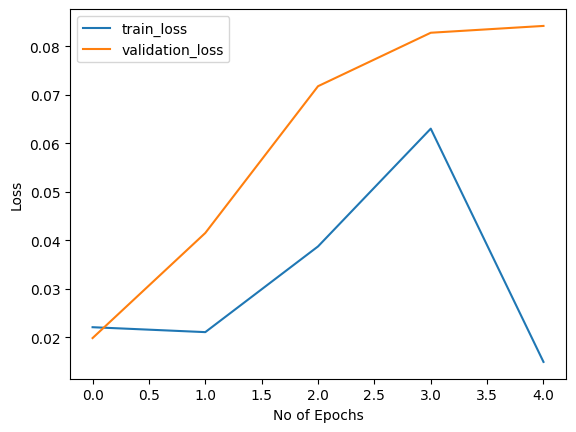

In [16]:
# Plot losses
plt.plot(train_losses, label='train_loss')
plt.plot(validation_losses, label='validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
# Accuracy function
def accuracy(model, loader):
    n_correct = 0
    n_total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]
    acc = n_correct / n_total
    return acc

# Calculate accuracies
train_acc = accuracy(custom_cnn, train_loader)
test_acc = accuracy(custom_cnn, test_loader)
validation_acc = accuracy(custom_cnn, validation_loader)

print(f"Train Accuracy : {train_acc}\nTest Accuracy : {test_acc}\nValidation Accuracy : {validation_acc}")

Train Accuracy : 0.9912044954800879
Test Accuracy : 0.9790051679586563
Validation Accuracy : 0.9775793273798214


In [18]:
# Transform index to disease
transform_index_to_disease = dataset.class_to_idx
transform_index_to_disease = dict([(value, key) for key, value in transform_index_to_disease.items()])


Original :  ntvillage/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964
Tomato_Septoria_leaf_spot


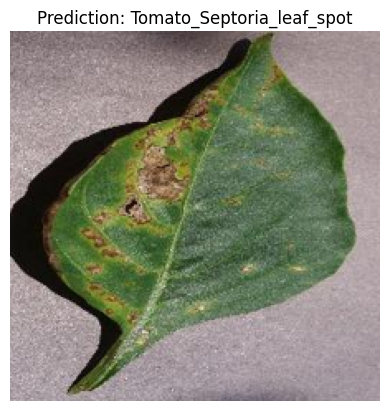

Original :  ntvillage/PlantVillage/Pepper__bell___Bacterial_spot/01613cd0-d3cd-4e96-945c-a312002037bf___JR_B.Spot 3262
Pepper__bell___Bacterial_spot


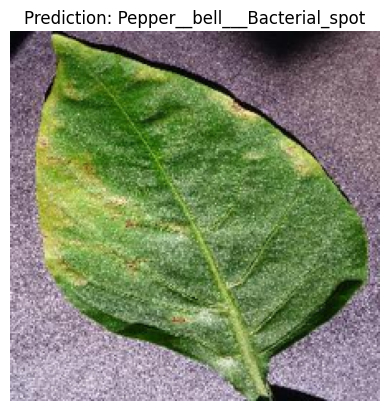

Original :  ntvillage/PlantVillage/Potato___Late_blight/0051e5e8-d1c4-4a84-bf3a-a426cdad6285___RS_LB 4640
Potato___Late_blight


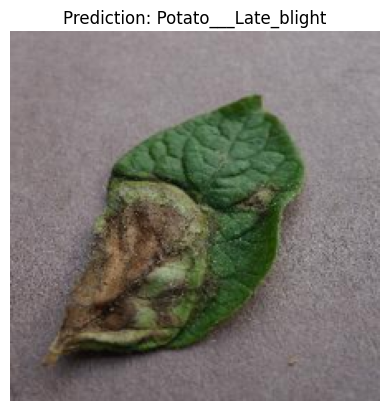

Original :  ntvillage/PlantVillage/Potato___Late_blight/01270f5c-a44b-4da7-9398-289088c197ab___RS_LB 2517
Tomato_Spider_mites_Two_spotted_spider_mite


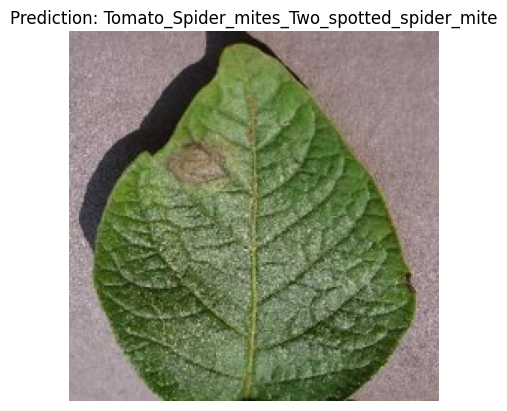

In [19]:
#Single prediction function
def single_prediction(model, image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))
    input_data = TF.to_tensor(image)
    input_data = input_data.view((-1, 3, 224, 224))
    input_data = input_data.to(device)
    model.eval()
    output = model(input_data)
    output = output.cpu().detach().numpy()
    index = np.argmax(output)
    print("Original : ", image_path[12:-4])
    pred_label = transform_index_to_disease[index]
    print(pred_label)

    # Display the image and prediction
    plt.imshow(image)
    plt.title(f"Prediction: {pred_label}")
    plt.axis('off')  # Turn off axis labels
    plt.show()


# Test single predictions

test_image_paths = [
    '/content/plantvillage/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG', # Added comma here
    '/content/plantvillage/PlantVillage/Pepper__bell___Bacterial_spot/01613cd0-d3cd-4e96-945c-a312002037bf___JR_B.Spot 3262.JPG', # Added comma here
    '/content/plantvillage/PlantVillage/Potato___Late_blight/0051e5e8-d1c4-4a84-bf3a-a426cdad6285___RS_LB 4640.JPG',
    '/content/plantvillage/PlantVillage/Potato___Late_blight/01270f5c-a44b-4da7-9398-289088c197ab___RS_LB 2517.JPG'
]

for image_path in test_image_paths:
    try:
        single_prediction(custom_cnn, image_path)
    except FileNotFoundError as e:
        print(f"Error: {e}")

In [20]:
#Evaluate Models Using Metrics

from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_with_metrics(model, loader):
    model.eval()
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    precision = precision_score(all_targets, all_predictions, average='weighted')
    recall = recall_score(all_targets, all_predictions, average='weighted')
    f1 = f1_score(all_targets, all_predictions, average='weighted')

    return precision, recall, f1

# Calculate metrics for validation set
precision, recall, f1 = evaluate_with_metrics(custom_cnn, validation_loader)
print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}')

Precision: 0.98, Recall: 0.98, F1-score: 0.98


In [21]:
# Perform error analysis to refine the model
def error_analysis(model, dataloader):
    model.eval()
    misclassified_images = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            misclassified_indices = (predicted != targets).nonzero(as_tuple=True)[0]
            for idx in misclassified_indices:
                misclassified_images.append((inputs[idx], targets[idx], predicted[idx]))
    return misclassified_images

misclassified_images = error_analysis(custom_cnn, validation_loader)
print(f"Number of misclassified images: {len(misclassified_images)}")


Number of misclassified images: 119


In [22]:
# Implement ensemble techniques for boosting performance
class EnsembleModel(nn.Module):
    def __init__(self, models):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList(models)

    def forward(self, x):
        outputs = [model(x) for model in self.models]
        avg_output = torch.mean(torch.stack(outputs), dim=0)
        return avg_output

In [23]:
# Train multiple models and create an ensemble
model1 = CustomCNN(targets_size).to(device)
model2 = CustomCNN(targets_size).to(device)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)
train_model(model1, train_loader, validation_loader, criterion, optimizer1, num_epochs=5)
train_model(model2, train_loader, validation_loader, criterion, optimizer2, num_epochs=5)


Epoch 1/5, Train Loss: 1.4716, Validation Loss: 0.8147, Validation Accuracy: 72.75%
Epoch 2/5, Train Loss: 0.7289, Validation Loss: 0.5197, Validation Accuracy: 82.33%
Epoch 3/5, Train Loss: 0.5397, Validation Loss: 0.4735, Validation Accuracy: 83.85%
Epoch 4/5, Train Loss: 0.4625, Validation Loss: 0.3689, Validation Accuracy: 87.36%
Epoch 5/5, Train Loss: 0.3932, Validation Loss: 0.2978, Validation Accuracy: 90.37%
Epoch 1/5, Train Loss: 1.3682, Validation Loss: 0.9004, Validation Accuracy: 69.20%
Epoch 2/5, Train Loss: 0.7521, Validation Loss: 0.7032, Validation Accuracy: 76.65%
Epoch 3/5, Train Loss: 0.5568, Validation Loss: 0.4461, Validation Accuracy: 84.40%
Epoch 4/5, Train Loss: 0.4552, Validation Loss: 0.4114, Validation Accuracy: 86.64%
Epoch 5/5, Train Loss: 0.3830, Validation Loss: 0.3386, Validation Accuracy: 88.30%


In [24]:
ensemble_model = EnsembleModel([model1, model2])
val_loss, val_accuracy = evaluate(ensemble_model, validation_loader, criterion)
print(f'Ensemble Model - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')


Ensemble Model - Validation Loss: 0.2471, Validation Accuracy: 92.04%


In [25]:
# Interpret model output
def interpret_model_output(model, image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))
    input_data = TF.to_tensor(image)
    input_data = input_data.view((-1, 3, 224, 224))
    input_data = input_data.to(device)
    model.eval()
    output = model(input_data)
    output = output.cpu().detach().numpy()
    index = np.argmax(output)
    pred_label = transform_index_to_disease[index]
    print(f"Prediction: {pred_label}")


In [26]:
torch.save(custom_cnn.state_dict(), 'plant_disease_model.pt')

In [27]:
from google.colab import files

In [28]:
files.download('plant_disease_model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
import pickle

# Save the entire model
with open('plant_disease_model.pkl', 'wb') as f:
    pickle.dump(custom_cnn, f)

In [30]:
files.download('plant_disease_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>